# Example 3: Normalize data to MNI template

This example covers the normalization of data. Some people prefer to normalize the data during the preprocessing, just before smoothing. I prefer to do the 1st-level analysis completely in subject space and only normalize the contrasts for the 2nd-level analysis.

For the current example, we will take the computed 1st-level contrasts from the previous experiment (again once done with fwhm=4mm and fwhm=8mm) and normalize them into MNI-space. To show two different approaches, we will do the normalization once with SPM and once with ANTs.

# Normalization with ANTs

The normalization with ANTs requires that you first compute the transformation matrix that would bring the anatomical images of each subject into template space. Depending on your system this might take a few hours per subject. To facilitate this step, I've already computed the transformation matrix.

The data for it can be found under:

In [1]:
# DJ: just copied there
!tree /data/antsdir/sub-0*/ 

/data/antsdir/sub-01/
|-- transformComposite.h5
`-- transform_Warped.nii.gz
/data/antsdir/sub-02/
|-- transformComposite.h5
`-- transform_Warped.nii.gz

0 directories, 4 files


And the script to compute those files can be found here:

In [2]:
# DJ: template from FSL I copied from Michael
#%load /data/antsdir/script_ANTS_registration.py 

**Now let's start with the ANTs normalization workflow!**

## Imports

First, we need to import all modules we later want to use.

In [3]:
from os.path import join as opj
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.fsl import Info

## Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [4]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-01', 'sub-02']

# task name
task_name = "fingerfootlips"

# Smoothing widths used during preprocessing
fwhm = [4, 8]

# DJ: can't find the file, copied from Michael, change the location
# Template to normalize to
#template = Info.standard_image('MNI152_T1_2mm.nii.gz')
template =  "/data/templates/fsl/MNI152_T1_2mm.nii.gz"

## Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [5]:
# Apply Transformation - applies the normalization matrix to contrast images
apply2con = MapNode(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='Linear',
                                    invert_transform_flags=[False],
                                    num_threads=1,
                                    reference_image=template,
                                    terminal_output='file'),
                    name='apply2con', iterfield=['input_image'])

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [6]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'con': opj(output_dir, '1stLevel',
                        '{subject_id}/fwhm-{fwhm_id}', '???_00??.nii'),
             'transform': opj('/data', 'antsdir', '{subject_id}',
                              'transformComposite.h5')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
subjFolders += [('_apply2con%s/' % (i), '') for i in range(9)] # number of contrast used in 1stlevel an.
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [7]:
# Initiation of the ANTs normalization workflow
antsflow = Workflow(name='antsflow')
antsflow.base_dir = opj(experiment_dir, working_dir)

# Connect up the ANTs normalization components
antsflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                             ('fwhm_id', 'fwhm_id')]),
                  (selectfiles, apply2con, [('con', 'input_image'),
                                            ('transform', 'transforms')]),
                  (apply2con, datasink, [('output_image', 'norm_ants.@con')]),
                  ])

## Visualize the workflow

It always helps to visualize your workflow.

170729-20:55:19,655 workflow INFO:
	 Generated workflow graph: /output/workingdir/antsflow/graph.dot.png (graph2use=colored, simple_form=True).


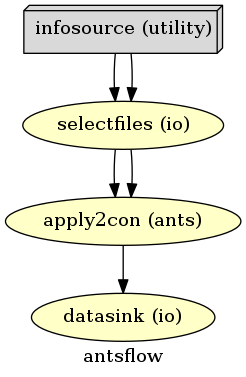

In [8]:
# Create ANTs normalization graph
antsflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(antsflow.base_dir, 'antsflow', 'graph.dot.png'))

##  Run the Workflow

Now that everything is ready, we can run the ANTs normalization workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [9]:
antsflow.run('MultiProc', plugin_args={'n_procs': 4})

170729-20:55:23,885 workflow INFO:
	 Workflow antsflow settings: ['check', 'execution', 'logging']
170729-20:55:23,988 workflow INFO:
	 Running in parallel.
170729-20:55:24,3 workflow INFO:
	 Executing: selectfiles.a3 ID: 0
170729-20:55:24,18 workflow INFO:
	 Executing: selectfiles.a2 ID: 3
170729-20:55:24,25 workflow INFO:
	 Executing node selectfiles.a3 in dir: /output/workingdir/antsflow/_fwhm_id_8_subject_id_sub-02/selectfiles
170729-20:55:24,45 workflow INFO:
	 Executing: selectfiles.a1 ID: 6
170729-20:55:24,70 workflow INFO:
	 Executing: selectfiles.a0 ID: 9
170729-20:55:24,50 workflow INFO:
	 Executing node selectfiles.a2 in dir: /output/workingdir/antsflow/_fwhm_id_4_subject_id_sub-02/selectfiles170729-20:55:24,77 workflow INFO:
	 Executing node selectfiles.a1 in dir: /output/workingdir/antsflow/_fwhm_id_8_subject_id_sub-01/selectfiles

170729-20:55:24,121 workflow INFO:
	 Executing node selectfiles.a0 in dir: /output/workingdir/antsflow/_fwhm_id_4_subject_id_sub-01/selectfiles

# Normalization with SPM12

The normalization with SPM12 is rather straight forward. The only thing we need to do is run the Normalize12 module. **So let's start!**

## Imports

First, we need to import all modules we later want to use.

In [10]:
from os.path import join as opj
from nipype.interfaces.spm import Normalize12
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.misc import Gunzip
from nipype.pipeline.engine import Workflow, Node

## Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [11]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-01', 'sub-02']

# task name
task_name = "fingerfootlips"

# Smoothing withds used during preprocessing
fwhm = [4, 8]

# DJ: can't find files, copied from Michael
# Template to normalize to
#template = '/opt/spm12/spm12_mcr/spm12/tpm/TPM.nii'
template =  "/data/templates/spm/TPM.nii"

## Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [12]:
# Gunzip - unzip the contrast image
gunzip = Node(Gunzip(), name="gunzip")

# Normalize - normalizes functional and structural images to the MNI template
normalize = Node(Normalize12(jobtype='estwrite',
                             tpm=template,
                             write_voxel_sizes=[2, 2, 2]),
                 name="normalize")

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [13]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'con': opj(output_dir, '1stLevel',
                        '{subject_id}/fwhm-{fwhm_id}', '???_00??.nii'),
             'anat': opj('/data', 'ds000114', '{subject_id}', 'ses-test', 'anat',
                         '{subject_id}_ses-test_T1w.nii.gz')}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [14]:
# Specify Normalization-Workflow & Connect Nodes
spmflow = Workflow(name='spmflow')
spmflow.base_dir = opj(experiment_dir, working_dir)

# Connect up SPM normalization components
spmflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('fwhm_id', 'fwhm_id')]),
                 (selectfiles, normalize, [('con', 'apply_to_files')]),
                 (selectfiles, gunzip, [('anat', 'in_file')]),
                 (gunzip, normalize, [('out_file', 'image_to_align')]),
                 (normalize, datasink, [('normalized_files', 'norm_spm.@files'),
                                        ('normalized_image', 'norm_spm.@image'),
                                        ]),
                 ])

## Visualize the workflow

It always helps to visualize your workflow.

170729-02:07:09,282 workflow INFO:
	 Generated workflow graph: /output/workingdir/spmflow/graph.dot.png (graph2use=colored, simple_form=True).


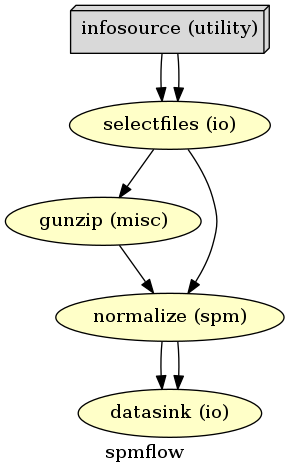

In [15]:
# Create SPM normalization graph
spmflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(spmflow.base_dir, 'spmflow', 'graph.dot.png'))

##  Run the Workflow

Now that everything is ready, we can run the SPM normalization workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [16]:
spmflow.run('MultiProc', plugin_args={'n_procs': 4})

170729-02:07:09,338 workflow INFO:
	 Workflow spmflow settings: ['check', 'execution', 'logging']
170729-02:07:09,406 workflow INFO:
	 Running in parallel.
170729-02:07:09,414 workflow INFO:
	 Executing: selectfiles.a3 ID: 0
170729-02:07:09,426 workflow INFO:
	 Executing: selectfiles.a2 ID: 4
170729-02:07:09,429 workflow INFO:
	 Executing node selectfiles.a3 in dir: /output/workingdir/spmflow/_fwhm_id_8_subject_id_sub-02/selectfiles
170729-02:07:09,437 workflow INFO:
	 Executing: selectfiles.a1 ID: 8
170729-02:07:09,440 workflow INFO:
	 Executing node selectfiles.a2 in dir: /output/workingdir/spmflow/_fwhm_id_4_subject_id_sub-02/selectfiles
170729-02:07:09,456 workflow INFO:
	 Executing: selectfiles.a0 ID: 12
170729-02:07:09,463 workflow INFO:
	 Executing node selectfiles.a1 in dir: /output/workingdir/spmflow/_fwhm_id_8_subject_id_sub-01/selectfiles
170729-02:07:09,475 workflow INFO:
	 Executing node selectfiles.a0 in dir: /output/workingdir/spmflow/_fwhm_id_4_subject_id_sub-01/selectf

# Comparison between ANTs and SPM normalization

Now that we ran the normalization with ANTs and SPM, let us compare their output.

In [17]:
%pylab inline
from nilearn.plotting import plot_stat_map
#anatimg = '/usr/share/fsl/data/standard/MNI152_T1_2mm.nii.gz'
anatimg = "/data/templates/fsl/MNI152_T1_2mm.nii.gz" #DJ: copied from Michael

Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/neuro/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


First, let's compare the normalization of the **anatomical** images:

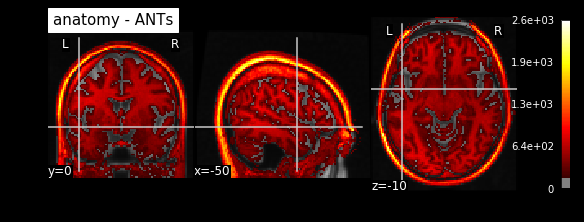

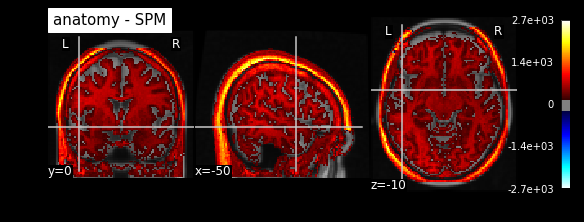

In [18]:
plot_stat_map(
    '/data/antsdir/sub-01/transform_Warped.nii.gz', title='anatomy - ANTs',
    bg_img=anatimg, threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10))
plot_stat_map(
    '/output/datasink/norm_spm/sub-01_fwhm4/wsub-01_ses-test_T1w.nii', title='anatomy - SPM',
    bg_img=anatimg, threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10))

And what about the **contrast** images?

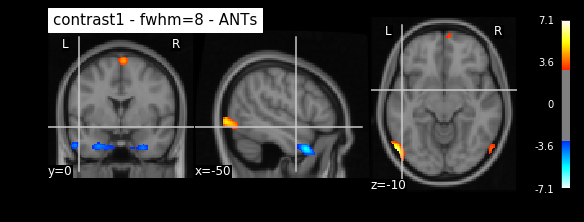

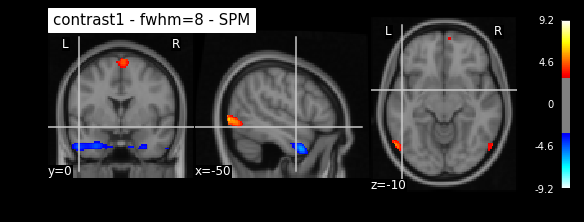

In [19]:
plot_stat_map(
    '/output/datasink/norm_ants/sub-01_fwhm8/con_0001_trans.nii', title='contrast1 - fwhm=8 - ANTs',
    bg_img=anatimg, threshold=3, display_mode='ortho', cut_coords=(-50, 0, -10))
plot_stat_map(
    '/output/datasink/norm_spm/sub-01_fwhm8/wcon_0001.nii', title='contrast1 - fwhm=8 - SPM',
    bg_img=anatimg, threshold=3, display_mode='ortho', cut_coords=(-50, 0, -10))